In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pickle
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import seaborn as sns
import scipy
from matplotlib import cm
%matplotlib inline

import plotting_functions
from tsne_plotting_functions import plot_continuous_tsne, plot_categorical_tsne

/home/nbbwang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Functions

In [2]:
path_to_transformations = "../../Pipeline_Outputs_Submitted/"
path_to_saved_tsne_embeddings = "../../Pipeline_Outputs_Submitted/final_tsne_saved_embeddings/"
pred_pathology_path =  "../../Pipeline_Outputs_Submitted/final_model/MDAD_predictions/CONSENSUS_PREDICTIONS.csv"

In [3]:
path_to_gs_data = "../../DATA/geneset_data/"
path_to_mdad_data = "../../DATA/MTL_data/"
phen_df = pd.read_csv("../../DATA/MTL_data/merged_phenotypes.csv")

In [4]:
phenotypes = ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"]


# LOAD EXPRESSION DATA 
num_components=500
with h5py.File(path_to_mdad_data + "ACT_MSBBRNA_ROSMAP_PCA.h5", 'r') as hf:
    print(list(hf.keys()))
    X_GE_PCA = hf["ge_transformed"][:,:500]
    Y = hf["labels"][:]
    labels_names= hf["labels_names"][:].astype(str)
labels_df = pd.DataFrame(Y, columns=labels_names.astype(str), dtype="str")

phen_df = phen_df.merge(labels_df, on=["sample_name", "filename"], how="inner")

with h5py.File(path_to_mdad_data + "ACT_MSBBRNA_ROSMAP.h5", 'r') as hf:
    print(list(hf.keys()))
    X_GE = hf["ge"][:]
    gene_symbols = hf["gene_symbols"][:].astype(str)
ge_df = pd.DataFrame(X_GE, columns=gene_symbols)



gmt_locations = {"REACTOME": path_to_gs_data + 'c2.all.v7.0.symbols_JustR.gmt',
                "KEGG": path_to_gs_data + 'c2.all.v7.0.symbols_JustK.gmt',
                "HALLMARK": path_to_gs_data + 'h.all.v7.0.symbols.gmt'}
for gset in ["mathys_celltypes", "sara_modules", "ben_modules", "mathys_microglia", "zhang_modules"]:
    gmt_locations[gset] = '%s%s/processed/gene_set.gmt'%(path_to_gs_data,gset)

['PCA_components_', 'ge_transformed', 'gene_symbols', 'labels', 'labels_names']
['ge', 'gene_symbols', 'labels', 'labels_names']


In [5]:

# example:   load_transformations("MTL", "consensus", "normed_KMeans", 1, None)
# example:   load_transformations("MTL", "single_run", 0, 1, None)
# example:   load_transformations("MLP", "single_run", 0, 1, "CERAD")

def load_transformations(embedding_source, METHOD, method_specifier, hidden_layer, METHOD_PHENOTYPE):
    
    if METHOD == "single_run":
        if embedding_source == "MTL":
            path = path_to_transformations + "/model_transformations/MTL/%i/%i.txt"%(hidden_layer, method_specifier)
        else:
            path = path_to_transformations + "/model_transformations/MLP/%s/%i/%i.txt"%(METHOD_PHENOTYPE, hidden_layer, method_specifier)
        return (np.loadtxt(path))
    elif METHOD == "consensus":
        path = path_to_transformations + "model_transformations_consensus/%i/%s/%s_50_embedding.txt"%(hidden_layer, method_specifier, embedding_source)
        embedding = np.loadtxt(path)
        return embedding
    

def calculate_unsupervised_transformations(X_GE_PCA, METHOD, dimensions):
    
    if METHOD == "KMeans":
        def kmeans_centroids_for_test(X_GE_PCA, cluster_labels):
            n_clusters = len(np.unique(cluster_labels))
            n,d = X_GE_PCA.shape

            new_centroids = np.zeros([n_clusters,n])
            for i in range(n_clusters):
                new_centroids[i] = np.mean(X_GE_PCA.T[np.where(cluster_labels ==i)], axis=0).reshape([1,-1])

            return new_centroids


        kmeans = KMeans(n_clusters=dimensions).fit(X_GE_PCA.T)
        X = kmeans_centroids_for_test(X_GE_PCA, kmeans.labels_).T

    elif METHOD == "PCA":
        pca = PCA(n_components = dimensions)
        pca.fit(X_GE_PCA)
        X = pca.transform(X_GE_PCA)[:, :dimensions]
    return X



def generate_geneset_embeddings(ge_df, gmt_file):
    gmt = pd.read_csv(gmt_file, header=None)
    gmt["names"] = gmt[0].apply(lambda x: x.split("\t")[0])
    gmt["genes"] = gmt[0].apply(lambda x: x.split("\t")[2:])
    
    ge_gset_df = pd.DataFrame(index=ge_df.index)
    
    for gset_i,row in gmt.iterrows():
        name = row["names"]
        genes_in_gs = np.intersect1d(np.array(row["genes"]), gene_symbols)
        ge_gset_df[name] = np.mean(ge_df[genes_in_gs],axis=1)
        
    return(ge_gset_df)



In [6]:
# READ IN PREDICTED PATHOLOGY (and resilience)
pred_pathology_df = pd.read_csv(pred_pathology_path)
pred_pathology_df = pred_pathology_df.merge(phen_df[["sample_name", "dementia", "age_censored"]], how="inner")


def scale_to_cat(X, val_min, val_max):
    cat_vals = [1/val_max*x for x in range(val_max+1)]
    dists = [[np.abs(v-cv) for cv in cat_vals] for v in X]
    cats = [np.argmin(v) for v in dists]
    return(np.array(cats).astype(float))

for phen in ["CERAD", "BRAAK"]:
    maxval = int(np.nanmax(phen_df[phen].values.astype(float)))
    pred_pathology_df[phen] = scale_to_cat(pred_pathology_df[phen].values, 0, maxval)
    

phen_df = phen_df.merge(pred_pathology_df[["sample_name"] + phenotypes],
             on=["sample_name"], how="left", suffixes=("", "_PRED"))

In [7]:
# example:   load_transformations("MTL", "consensus", "normed_KMeans", 1, None)
# example:   load_transformations("MTL", "single_run", 0, 1, None)

MTL 1 normed_KMeans_medoids None
loaded embedding from: 
 ../../Pipeline_Outputs_Submitted/final_tsne_saved_embeddings/MTL/1/consensus/normed_KMeans_medoids/embedded_data.h5
MLP 1 0 CERAD
loaded embedding from: 
 ../../Pipeline_Outputs_Submitted/final_tsne_saved_embeddings/MLP/CERAD/1/0/embedded_data.h5
MLP 1 0 BRAAK
loaded embedding from: 
 ../../Pipeline_Outputs_Submitted/final_tsne_saved_embeddings/MLP/BRAAK/1/0/embedded_data.h5


/home/nbbwang/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


MLP 1 0 PLAQUES
loaded embedding from: 
 ../../Pipeline_Outputs_Submitted/final_tsne_saved_embeddings/MLP/PLAQUES/1/0/embedded_data.h5
MLP 1 0 TANGLES
loaded embedding from: 
 ../../Pipeline_Outputs_Submitted/final_tsne_saved_embeddings/MLP/TANGLES/1/0/embedded_data.h5
MLP 1 0 ABETA_IHC
loaded embedding from: 
 ../../Pipeline_Outputs_Submitted/final_tsne_saved_embeddings/MLP/ABETA_IHC/1/0/embedded_data.h5
MLP 1 0 TAU_IHC
loaded embedding from: 
 ../../Pipeline_Outputs_Submitted/final_tsne_saved_embeddings/MLP/TAU_IHC/1/0/embedded_data.h5
modules 1 zhang_modules None
loaded embedding from: 
 ../../Pipeline_Outputs_Submitted/final_tsne_saved_embeddings/modules/zhang_modules/embedded_data.h5
modules 1 sara_modules None
loaded embedding from: 
 ../../Pipeline_Outputs_Submitted/final_tsne_saved_embeddings/modules/sara_modules/embedded_data.h5
modules 1 ben_modules None
loaded embedding from: 
 ../../Pipeline_Outputs_Submitted/final_tsne_saved_embeddings/modules/ben_modules/embedded_data.h5


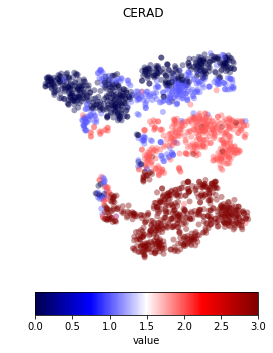

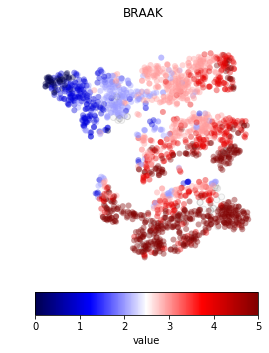

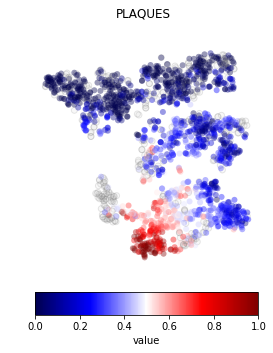

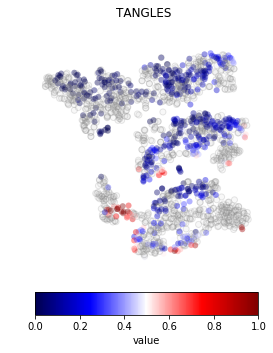

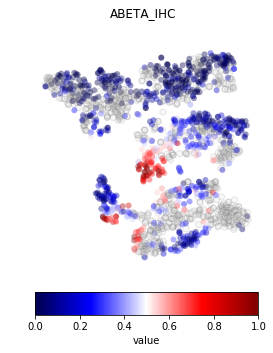

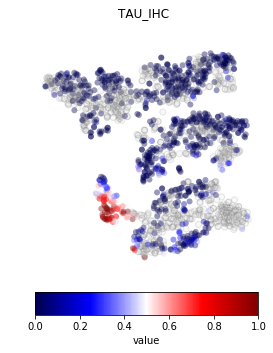

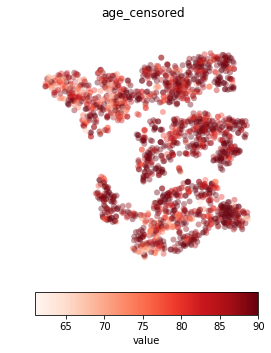

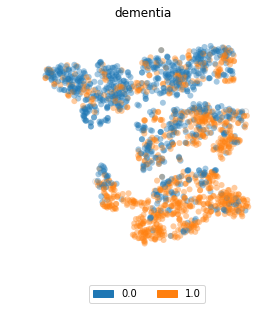

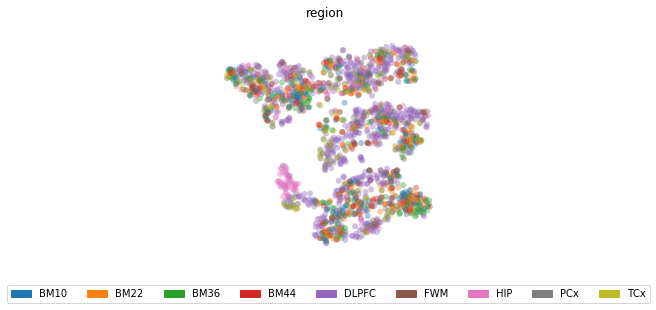

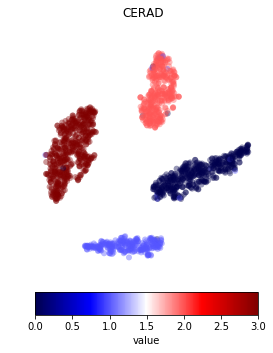

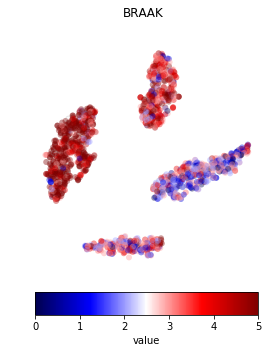

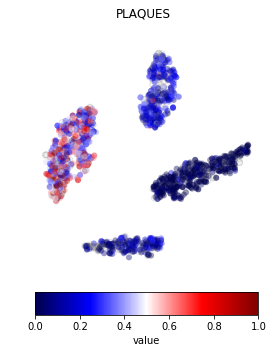

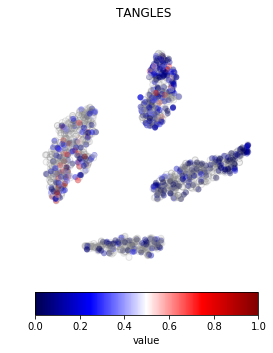

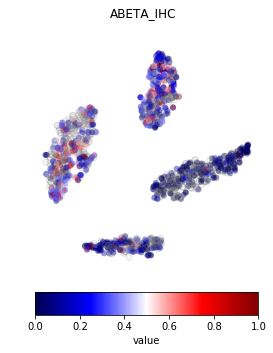

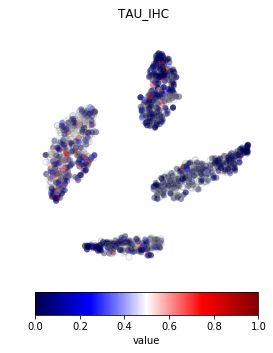

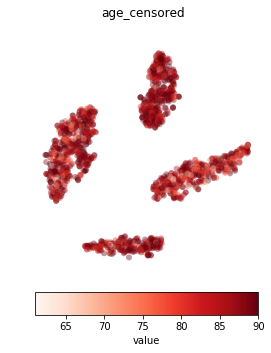

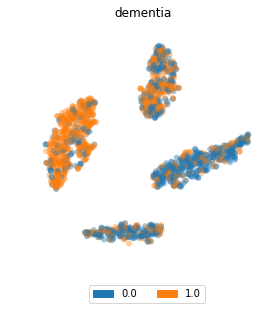

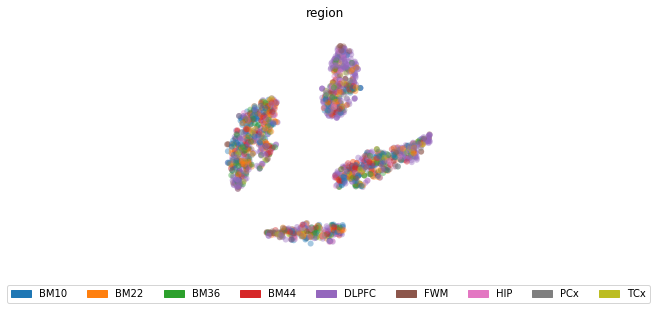

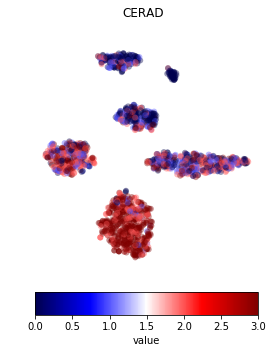

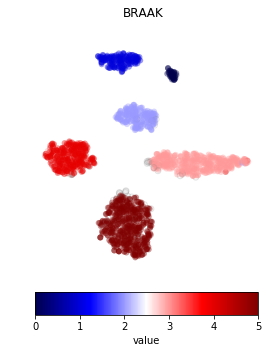

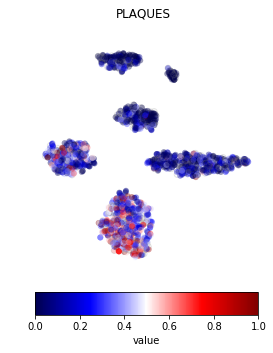

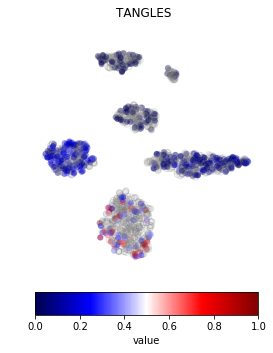

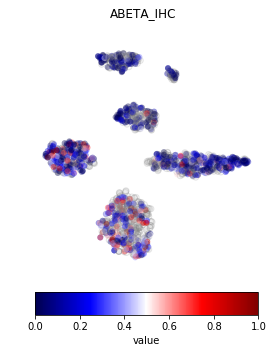

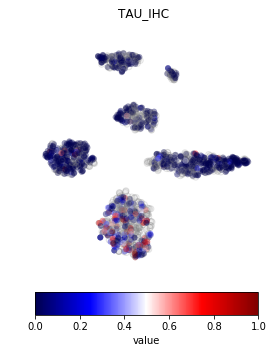

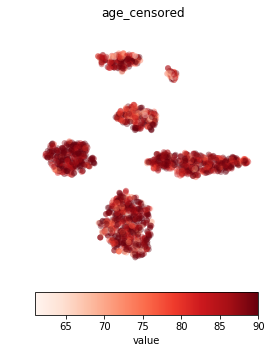

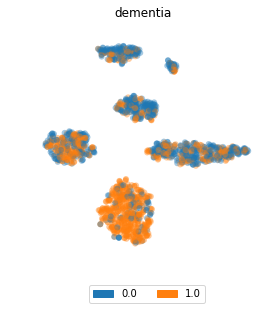

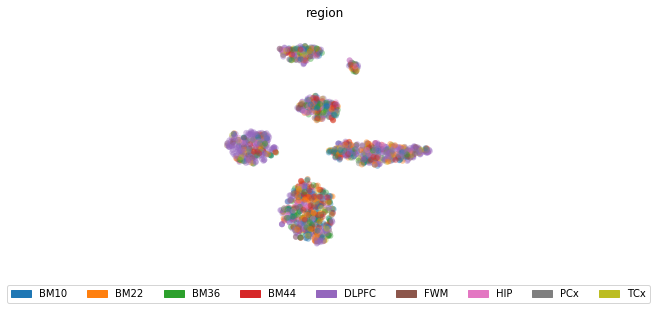

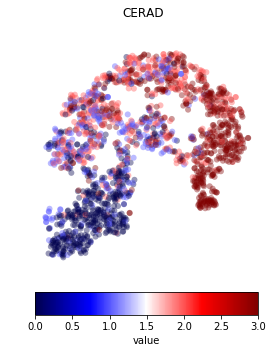

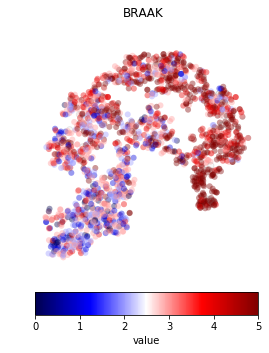

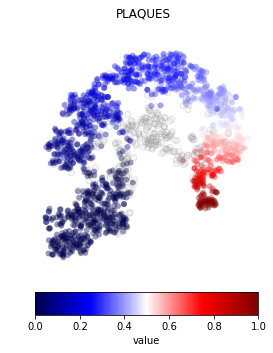

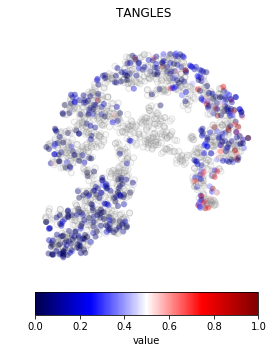

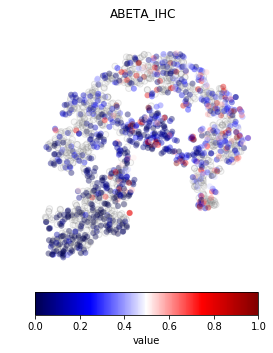

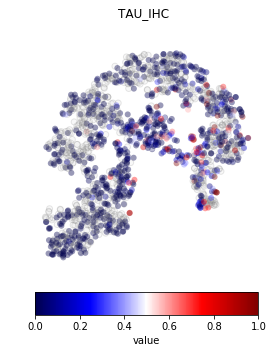

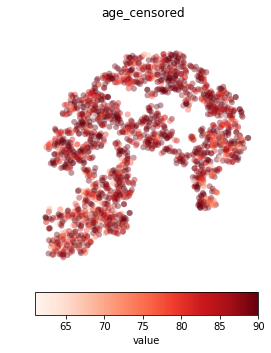

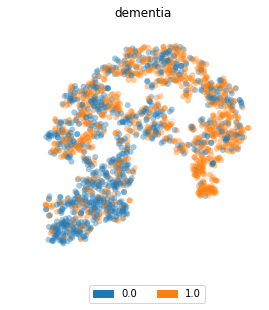

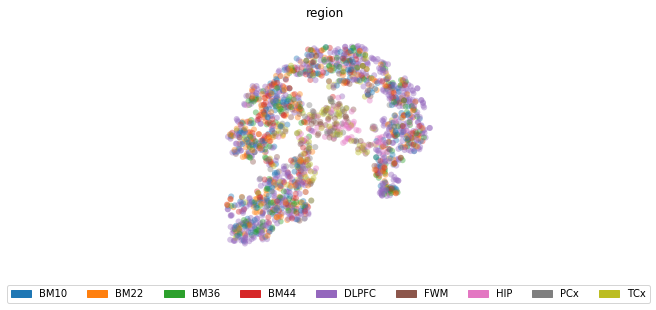

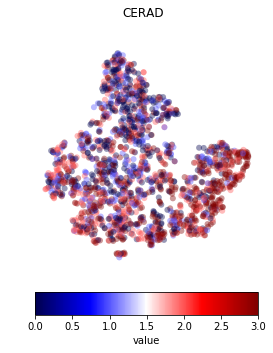

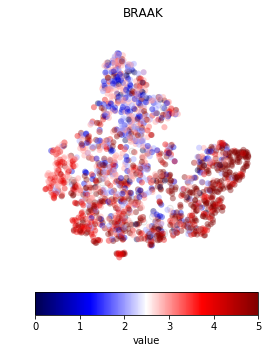

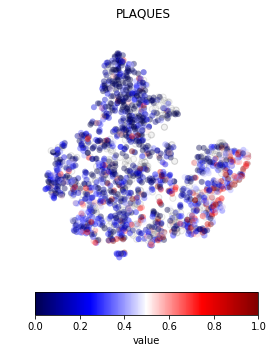

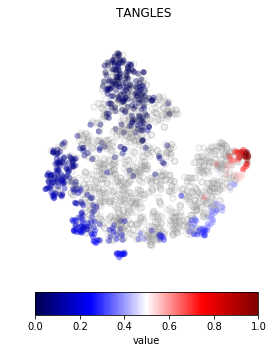

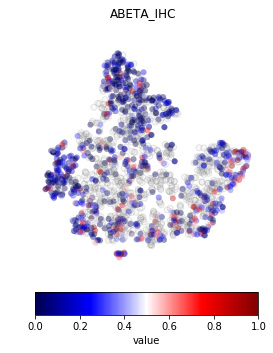

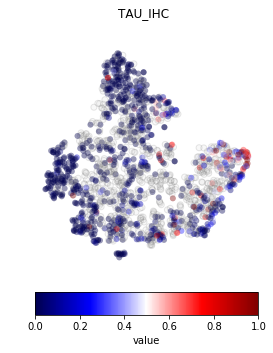

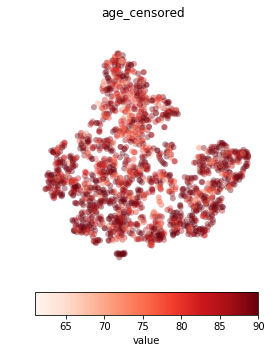

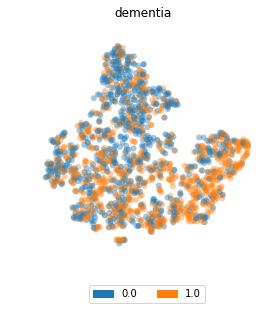

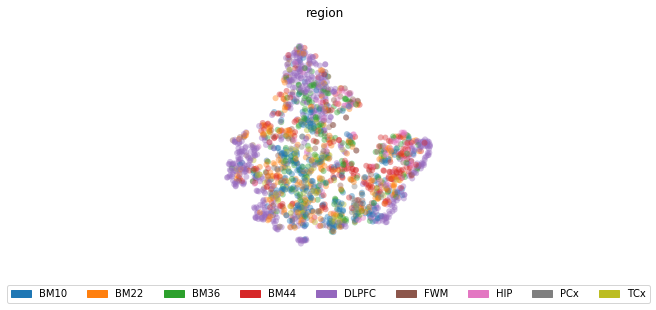

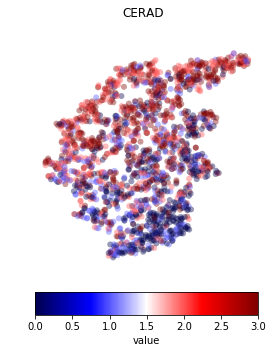

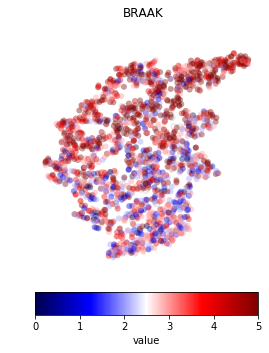

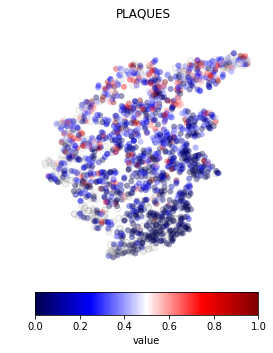

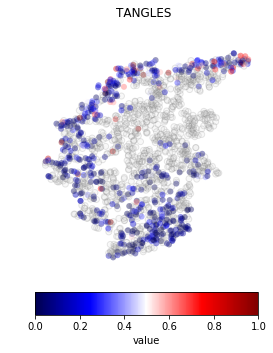

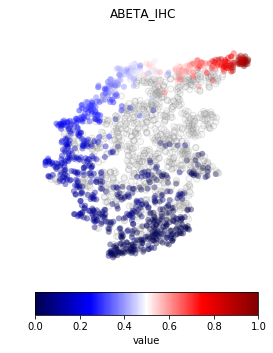

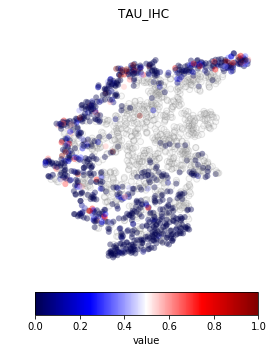

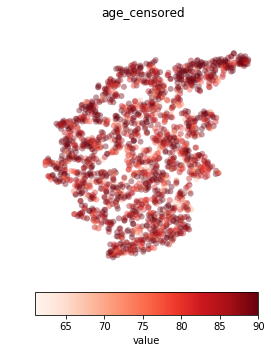

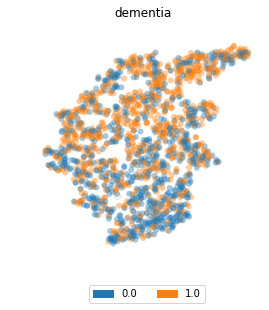

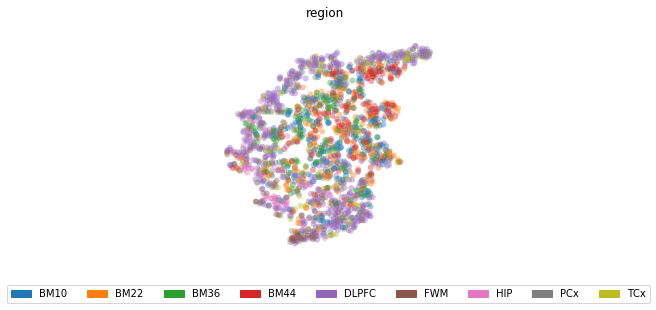

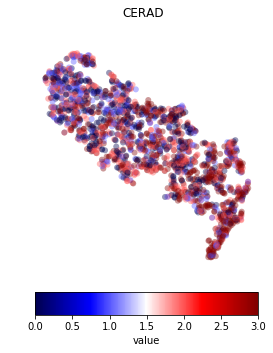

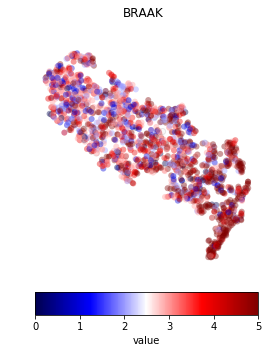

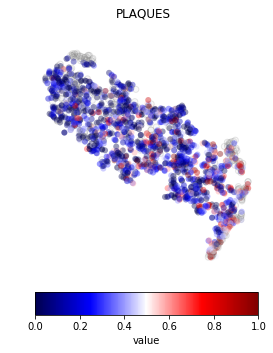

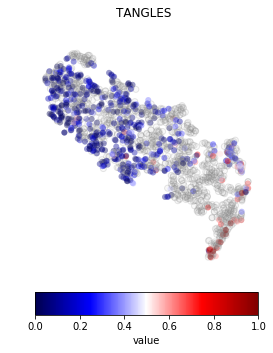

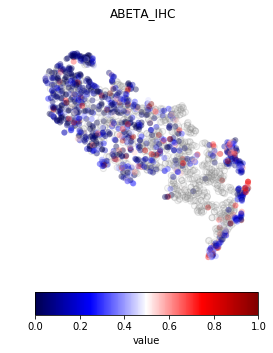

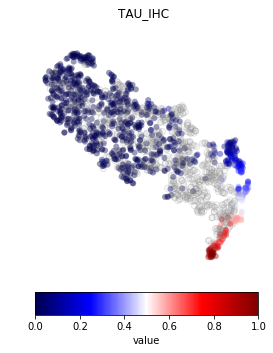

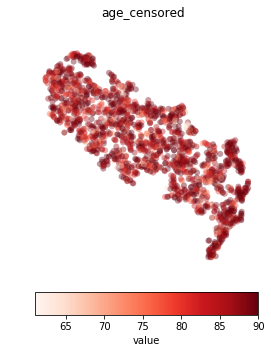

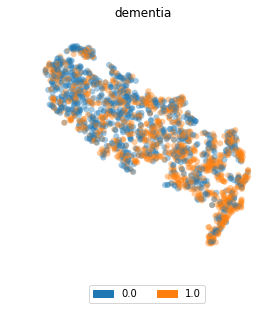

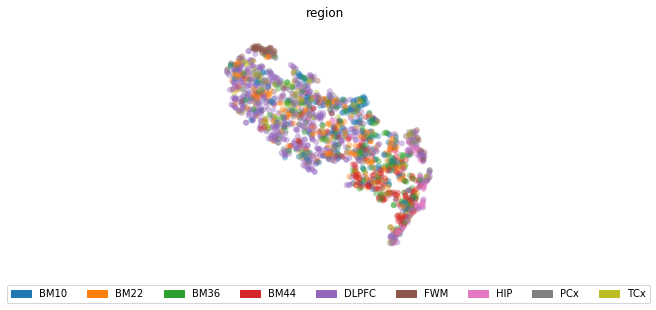

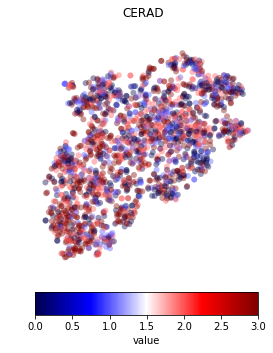

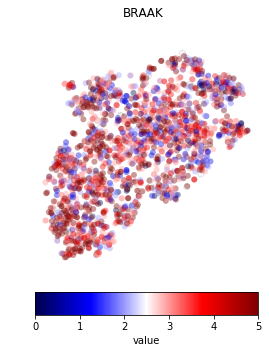

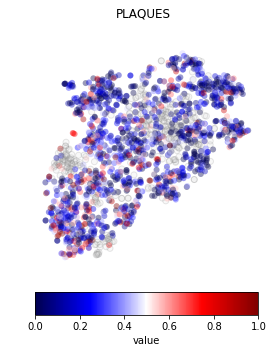

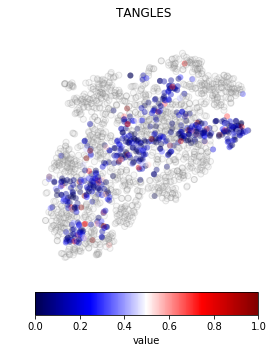

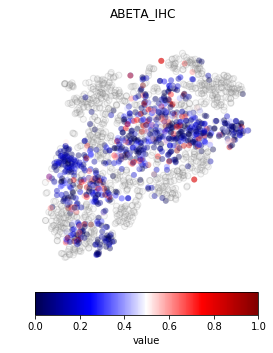

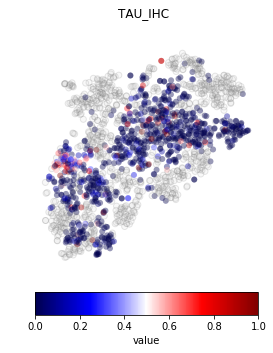

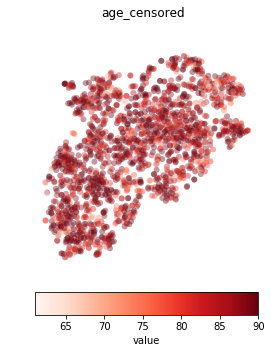

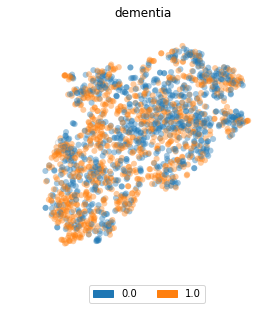

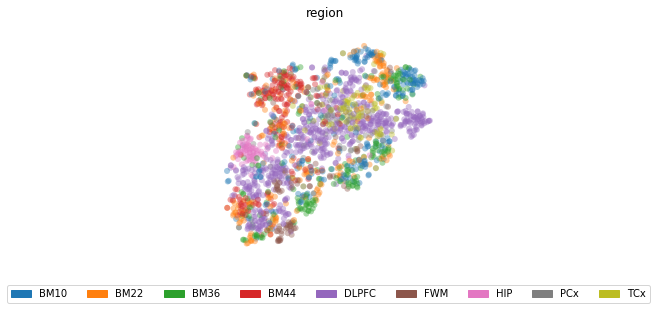

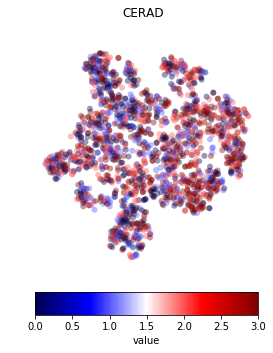

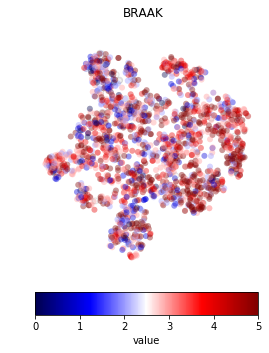

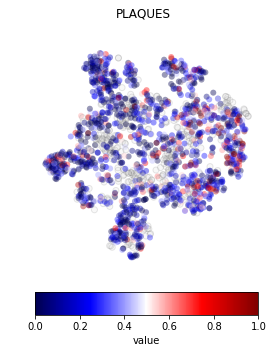

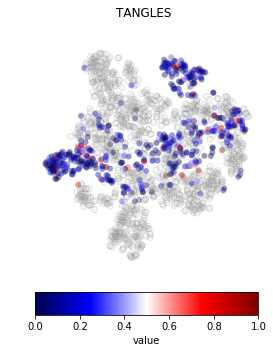

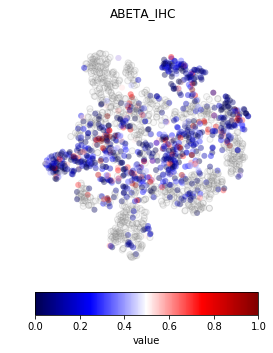

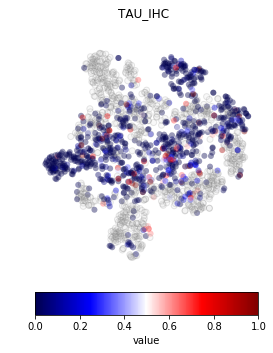

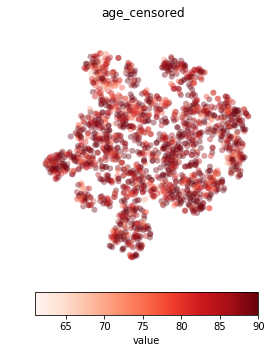

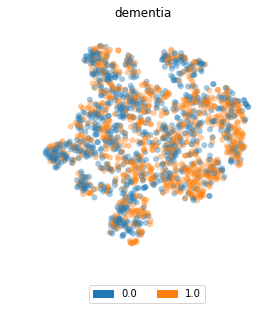

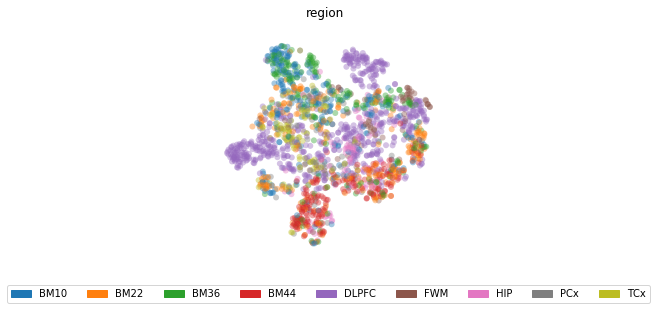

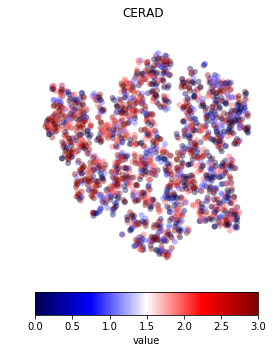

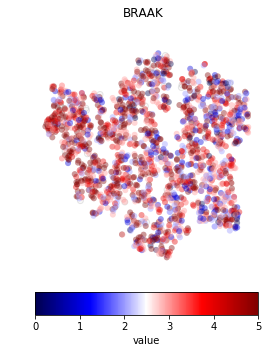

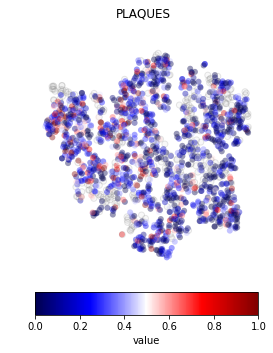

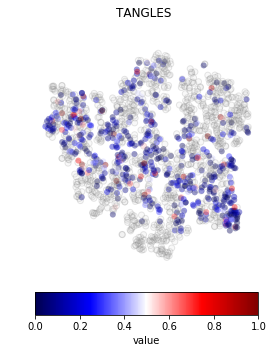

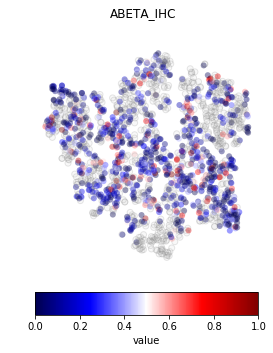

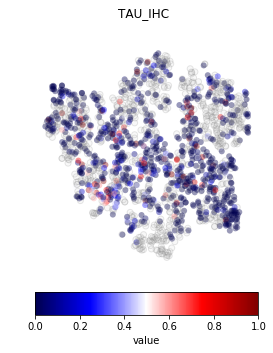

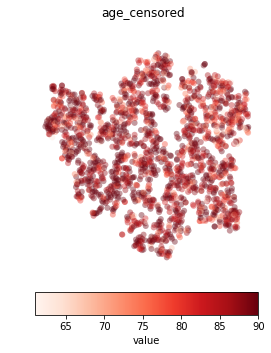

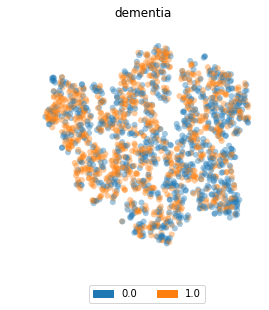

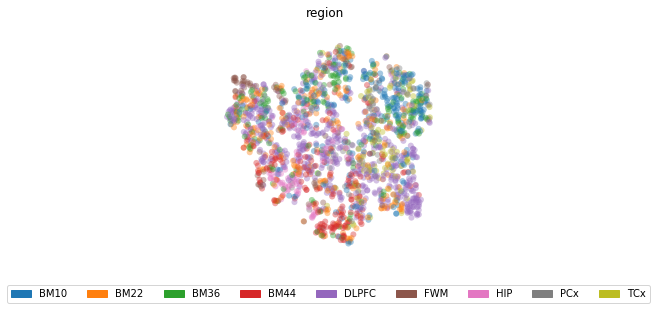

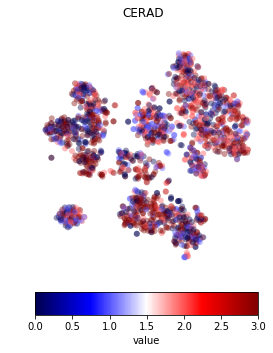

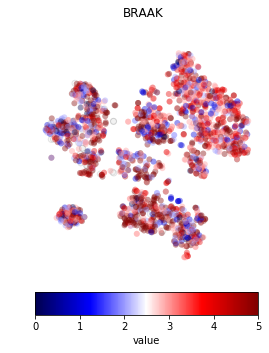

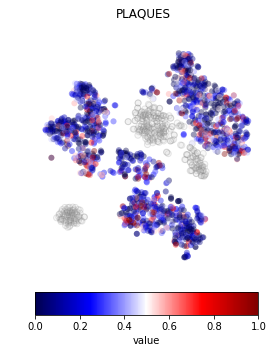

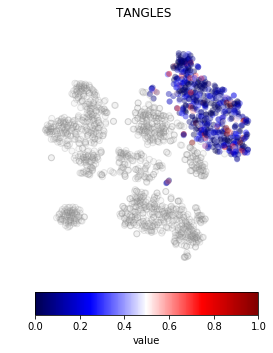

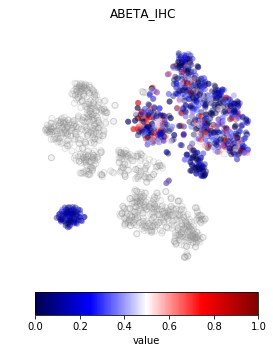

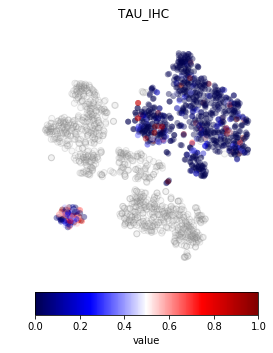

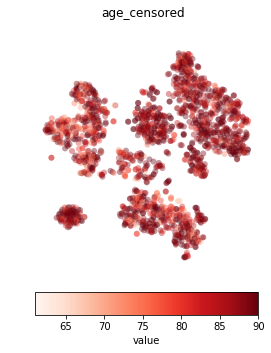

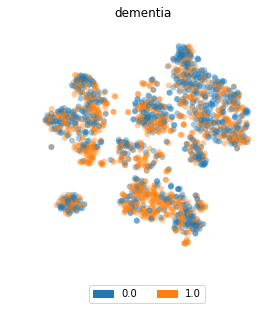

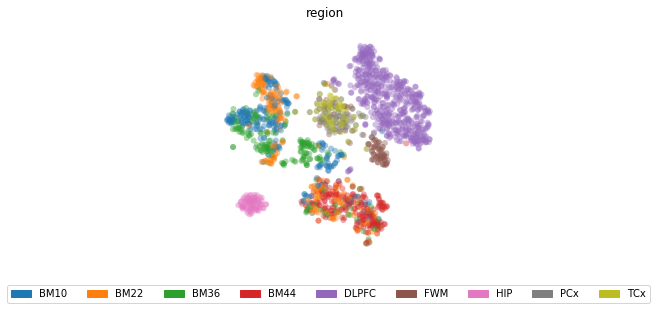

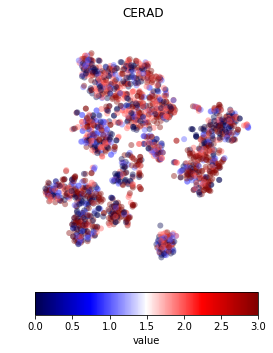

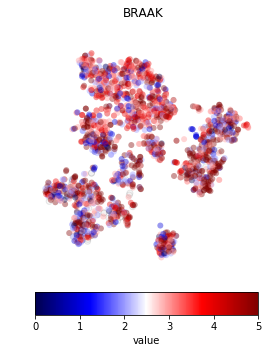

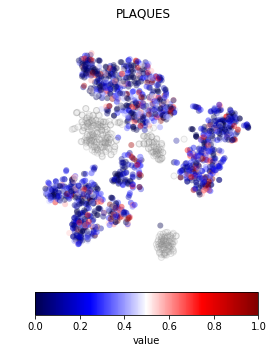

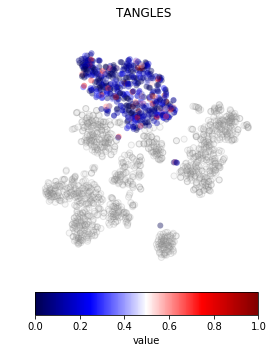

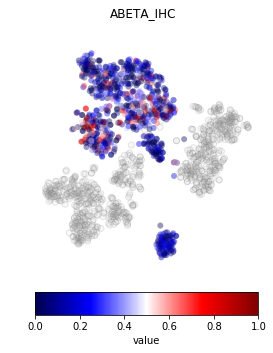

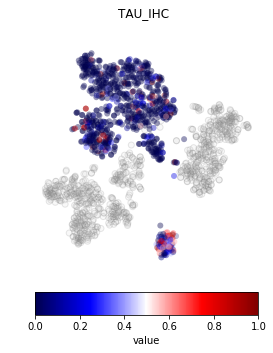

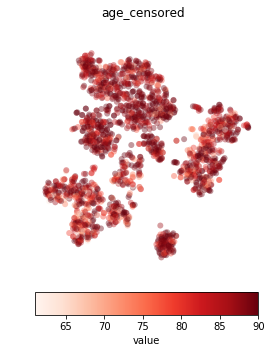

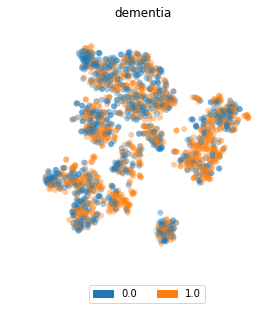

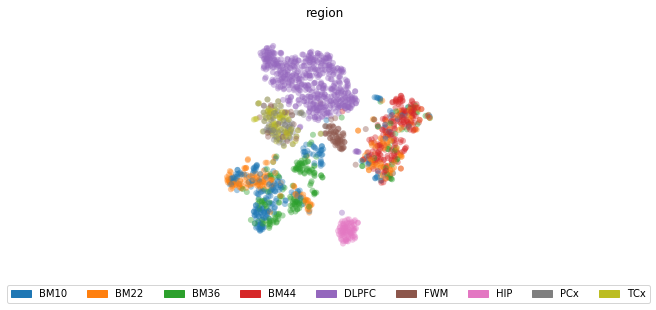

In [8]:
# the t-sne algorithm produces a different embedding everytime, so we can save one run for future reference 
# setting calc_new to True will cause the originally saved tsne embedding to be overwritten
calc_new = False

# when true, the nan values will show up as grey dots. If set to False, they will be entirely hidden from the plot.
nangray = True

# for MD-AD, can show either the consensus embedding or just a single run's embedding
consensus=True
unsupervised_dim = 50

for method in ["MTL","MLP", "modules", "PCA", "KMeans"]:
    for hidden_layer in [1]:
        
        if method=="MLP":
            # phens_to_check refers to whether there are different embeddings generated for different phenotypes (i.e., MLPs)
            phens_to_check = phenotypes
        else:
            phens_to_check = [None]
        
        
        for phenotype in phens_to_check:
            if consensus and method=="MTL":
                specifics = ["normed_KMeans_medoids"]
            elif method == "modules":
                specifics = ["zhang_modules", "sara_modules", "ben_modules"]
            else:
                specifics = [0]

            for specific in specifics:
                if method in ["PCA", "KMeans"]:
                    X = calculate_unsupervised_transformations(X_GE_PCA, method, unsupervised_dim)
                    savefolder = "%s/%i/"%(method, unsupervised_dim)
                elif method == "modules":
                    X = generate_geneset_embeddings(ge_df, gmt_locations[specific]).values
                    savefolder = "%s/%s/"%(method, specific)
                else:
                    if consensus and method=="MTL":
                        subfolder = "consensus"
                    else:
                        subfolder = "single_run"
                    
                    X = load_transformations(method, subfolder, specific, hidden_layer, phenotype)
                    
                    if method=="MLP":
                        savefolder = "%s/%s/%i/%s/"%(method, phenotype,  hidden_layer, specific)
                    else:
                        savefolder = "%s/%i/%s/%s/"%(method, hidden_layer, subfolder, specific)

                print(method, hidden_layer, specific, phenotype)
                random_order = np.random.permutation(len(X))                    

                if calc_new:
                    print(X.shape)
                    tsne = TSNE(n_components=2, perplexity=30)
                    E = tsne.fit_transform(X)

                    os.makedirs(os.path.dirname(path_to_saved_tsne_embeddings + savefolder), exist_ok=True)
                    with h5py.File(path_to_saved_tsne_embeddings + savefolder + "embedded_data.h5", 'w') as hf:
                        hf.create_dataset("E", data=E)
    #           otherwise, load in a previously calculated embedding
                else:
                    with h5py.File(path_to_saved_tsne_embeddings + savefolder + "embedded_data.h5", 'r') as hf:
                        E = hf["E"][:]
                    print ("loaded embedding from: \n %s%sembedded_data.h5"%(path_to_saved_tsne_embeddings, savefolder))

                E = E[random_order]           

                for i,phen in enumerate(phenotypes + ["age_censored", "dementia", "region"]):
                    phens = phen_df[phen].values[random_order]
                    phens_s = phens.astype(str)

                    if len(np.unique(phens_s[phens_s != "nan"])) < 4 or phen in ["apoe_genotype", "region"]:
                        plot_categorical_tsne(E, phens, phen, "tab10", nangray, save_path=None)
                    
                    elif phen == "age_censored":
                        plot_continuous_tsne(E, phens, phen, matplotlib.cm.Reds, nangray, save_path=None)

                    else:
                        plot_continuous_tsne(E, phens, phen, matplotlib.cm.seismic, nangray, save_path=None)